# Browsing history

In [1]:
import sqlite3 as sqlite3
import pandas as pd
limit = 10
con_brave_mac15 = sqlite3.connect('../data/browsing-history/brave-mac15-history')
con_brave_imac = sqlite3.connect('../data/browsing-history/brave-imac-history')
con_moz_mac15 = sqlite3.connect('../data/browsing-history/moz-mac15-places.sqlite')
con_moz_imac = sqlite3.connect('../data/browsing-history/moz-imac-places.sqlite')

OperationalError: unable to open database file

In [3]:
# only for brave/chrome
terms1 = pd.read_sql('select * from keyword_search_terms', con_brave_mac15)
terms2 = pd.read_sql('select * from keyword_search_terms', con_brave_imac)
keyword_search_terms = pd.concat([terms1, terms2], sort=False)
# keyword_search_terms.head()

## Prepare final data

In [ ]:
query_moz = 'SELECT \
    datetime(moz_historyvisits.visit_date/1000000,"unixepoch") as visit_time, \
    moz_places.url, \
    moz_places.title \
FROM moz_places, moz_historyvisits \
WHERE moz_places.id = moz_historyvisits.place_id'

his_moz_mac15 = pd.read_sql(query_moz, con_moz_mac15)
his_moz_imac = pd.read_sql(query_moz, con_moz_imac)

# add browser and device features
his_moz_mac15['browser'] = 'moz'
his_moz_imac['browser'] = 'moz'
his_moz_mac15['device'] = 'mac15'
his_moz_imac['device'] = 'imac'

In [1069]:
query_brave = 'select urls.url, title, \
      datetime(visit_time/1000000-11644473600, "unixepoch") as visit_time \
    from urls, visits \
    where urls.id = visits.url'

his_brave_mac15 = pd.read_sql(query_brave, con_brave_mac15)
his_brave_imac = pd.read_sql(query_brave, con_brave_imac)

# add browser and device features
his_brave_mac15['browser'] = 'brave'
his_brave_imac['browser'] = 'brave'
his_brave_mac15['device'] = 'mac15'
his_brave_imac['device'] = 'imac'

In [1070]:
# First make sure the columns are the same in both data frames
# Then, combine both firefox and brave history
his = pd.concat([his_moz_mac15, his_moz_imac,
                 his_brave_mac15, his_brave_imac], sort=False)
# his.head(2)

## Add features

Add domain, path and query

In [1071]:
from urllib.parse import urlparse

his['domain'] = his['url'].apply(lambda x: urlparse(x).netloc)
his['path'] = his['url'].apply(lambda x: urlparse(x).path)
his['query'] = his['url'].apply(lambda x: urlparse(x).query)

Add year, month, hour and day of week

In [1072]:
from datetime import datetime

def to_date(d, fmt):
    return datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime(fmt)

his['visit_day'] = his['visit_time'].apply(lambda x: to_date(x, '%a'))
his['visit_month'] = his['visit_time'].apply(lambda x: to_date(x, '%b'))
his['visit_hour'] = his['visit_time'].apply(lambda x: to_date(x, '%H'))
his['visit_year'] = his['visit_time'].apply(lambda x: to_date(x, '%Y'))

## Final data

In [1073]:
data = his
data.head(2)

,visit_time,url,title,browser,device,domain,path,query,visit_day,visit_month,visit_hour,visit_year
0,2019-02-04 12:05:41,https://www.mozilla.org/en-US/firefox/central/,None,moz,mac15,www.mozilla.org,/en-US/firefox/central/,,Mon,Feb,12,2019
1,2019-02-04 12:14:50,https://www.mozilla.org/en-US/firefox/central/,None,moz,mac15,www.mozilla.org,/en-US/firefox/central/,,Mon,Feb,12,2019


# Stats

## Most visited domains

What are the most visited domains

In [1074]:
# top visited domains
data['domain'].value_counts().head(limit)

github.com                     39335
duckduckgo.com                 37821
organise.earth                 16612
extinctionrebellion.nl          8711
docs.google.com                 8325
www.youtube.com                 7504
localhost:4000                  6672
www.google.com                  6478
base.extinctionrebellion.nl     6075
localhost:8000                  5102
Name: domain, dtype: int64

## Total visited domains

In [1075]:
data['domain'].nunique()

5543

## Date ranges

In [1076]:
data['visit_time'].min()

'2016-04-17 12:52:04'

In [1077]:
data['visit_time'].max()

'2020-04-09 17:48:06'

## Most occuring words

In [1078]:
from functools import reduce 
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# nltk.download('punkt')
# nltk.download('stopwords')

# @todo Expensive method! Calculate O(n) and rewrite
def bow(arr = [], n = limit):
    # get all titles
    titles = map(nltk.word_tokenize, arr)

    # flatten titles list to one dimensional array
    title_words = reduce(lambda init, a: init + a, titles)

    # make a list of stop words to filter titles from
    stop = stopwords.words('english') + list(string.punctuation) + ['\'\'', '``', '—', '·']

    # filter stop words from titles
    title_words_filtered = [i for i in title_words if i.strip() not in stop]

    return pd.Series(title_words_filtered).value_counts().head(n)

### in keyword search (only for brave/chrome)

In [1079]:
bow(keyword_search_terms['term'].unique())

yt           86
python       59
docker       41
file         36
mac          33
nextcloud    33
postgres     31
pipenv       25
pandas       23
apple        21
dtype: int64

### in page titles

In [1080]:
# this is expensive for large datasets, optimize!
# bow(his['title'].dropna().unique())

## Most visited urls

In [1081]:
data['url'].value_counts().head(limit)

https://github.com/                                    1818
https://organise.earth/                                 945
https://base.extinctionrebellion.nl/                    907
https://mail.google.com/mail/u/0/#inbox                 871
https://organise.earth/xr-netherlands/channels/tech     871
https://organise.earth/xr-netherlands                   869
https://extinctionrebellion.nl/                         867
https://teams.microsoft.com/go#                         853
https://github.com/notifications                        783
https://github.com/madhums                              762
Name: url, dtype: int64

## Most visited github projects

From the most visited domains, github.com seems to be the top. Let's see which projects were most visited.

In [1082]:
github_paths = data[(data['domain'] == 'github.com')]['path']
github_project_paths = github_paths[github_paths.apply(lambda p: len(p.split('/')[1:]) > 1)]
github_project_paths.value_counts().head(limit)

/q-m/questionmark-web/issues                  795
/q-m/questionmark-web                         472
/q-m/questionmark-web/pulls                   456
/DaanMeijer/extinction-rebellion-nl           355
/madhums/node-express-mongoose-demo           353
/DaanMeijer/extinction-rebellion-nl/issues    222
/keystonejs/keystone/search                   209
/xrnl/extinction-rebellion-nl                 208
/q-m/questionmark-web/                        198
/notifications/beta                           188
Name: path, dtype: int64

# Visualisations

In [1083]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Heatmap of active weekday vs month

In [1084]:
month_day = data.pivot_table(index='visit_month',columns='visit_day', 
                             aggfunc='count', fill_value=0, values='visit_year')
month_day.head(2)

visit_day,Fri,Mon,Sat,Sun,Thu,Tue,Wed
visit_month,,,,,,,
Apr,2533,5613,1624,2016,3503,6550,6733
Aug,5768,4711,3438,2259,5720,3177,3774


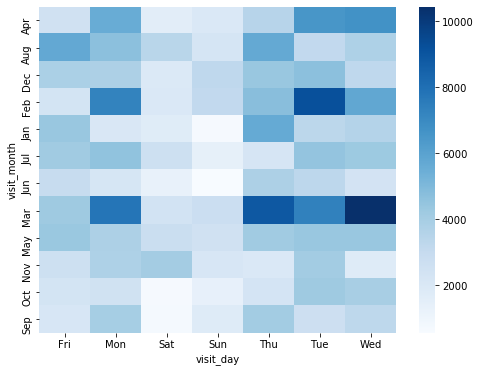

In [1085]:
plt.figure(figsize=(8, 6))
sns.heatmap(month_day, cmap='Blues')

### clustering the above

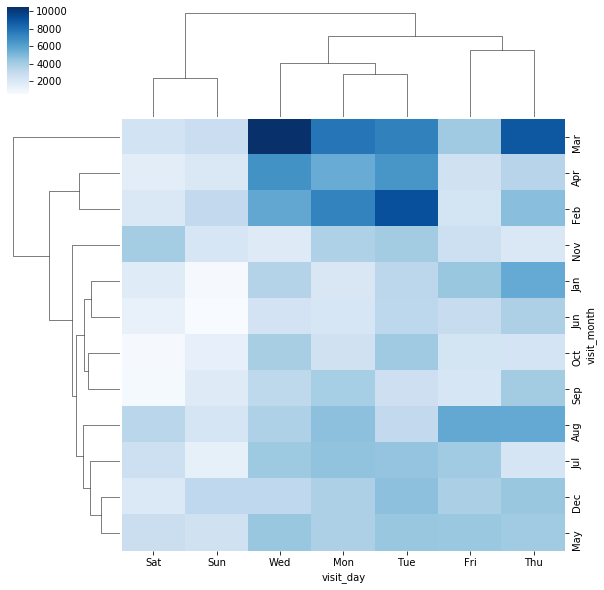

In [1086]:
sns.clustermap(month_day, cmap='Blues')

In [1087]:
months = [datetime(2008, x, 1).strftime('%b') for x in range(1, 13)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Browsing activity per week

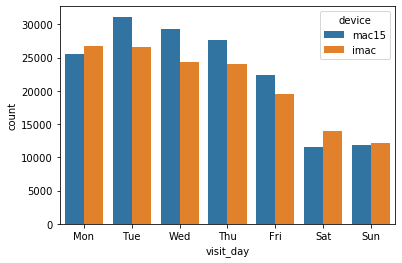

In [1088]:
sns.countplot(x='visit_day',data=data, order=days, hue='device')

### Comparing top domains like github, netflix, youtube etc

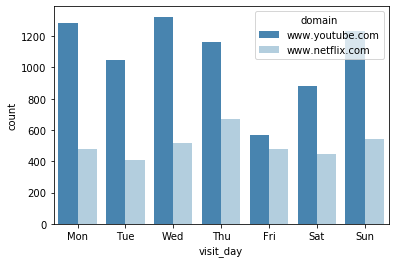

In [1104]:
sns.countplot(x='visit_day',
  data=data[(data['domain'] == 'www.youtube.com') | (data['domain'] == 'www.netflix.com')], 
  order=days, hue='domain', palette='Blues_r')

## Browsing activity per week divided over months

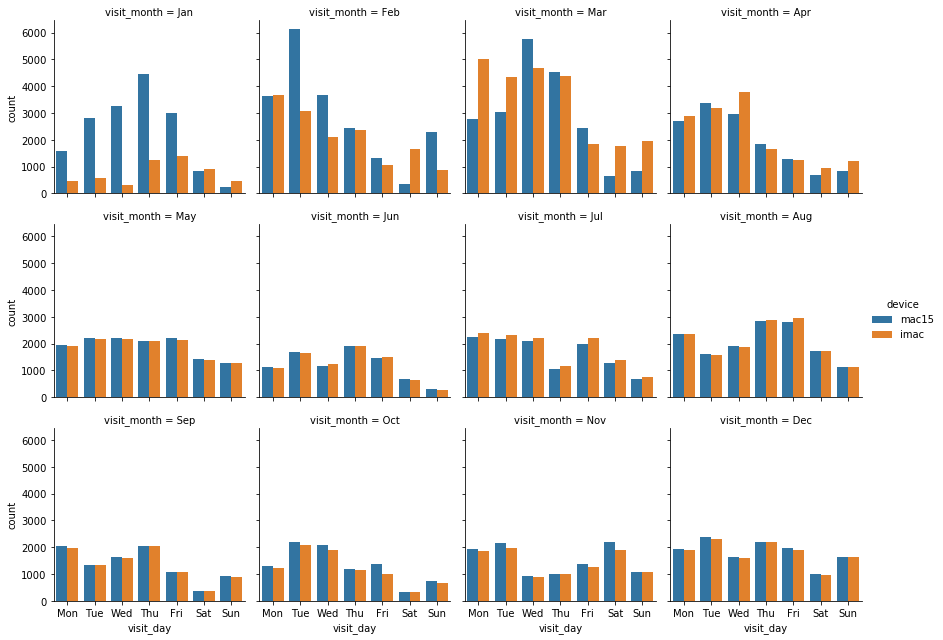

In [1090]:
sns.catplot(x='visit_day',data=data, 
            kind='count', col='visit_month', col_wrap=4, height=3,
            order=days, col_order=months, hue='device')

## Browsing activity per hour

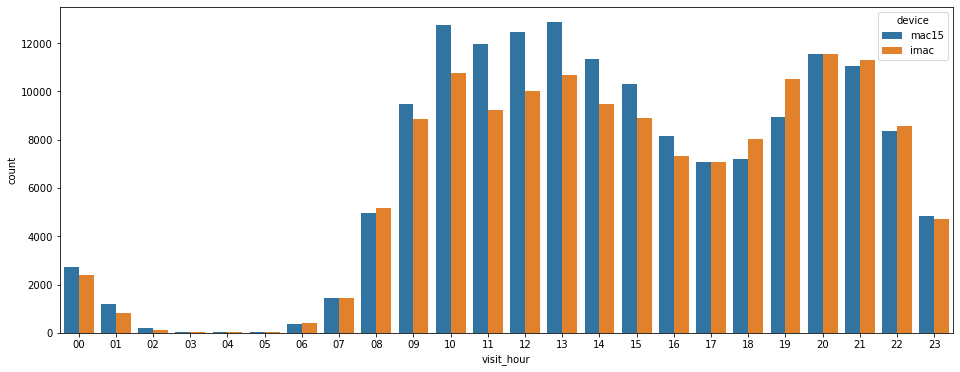

In [1091]:
plt.figure(figsize=(16, 6))
sns.countplot(x='visit_hour',data=data, hue='device')

## Browsing activity per hour divided over months

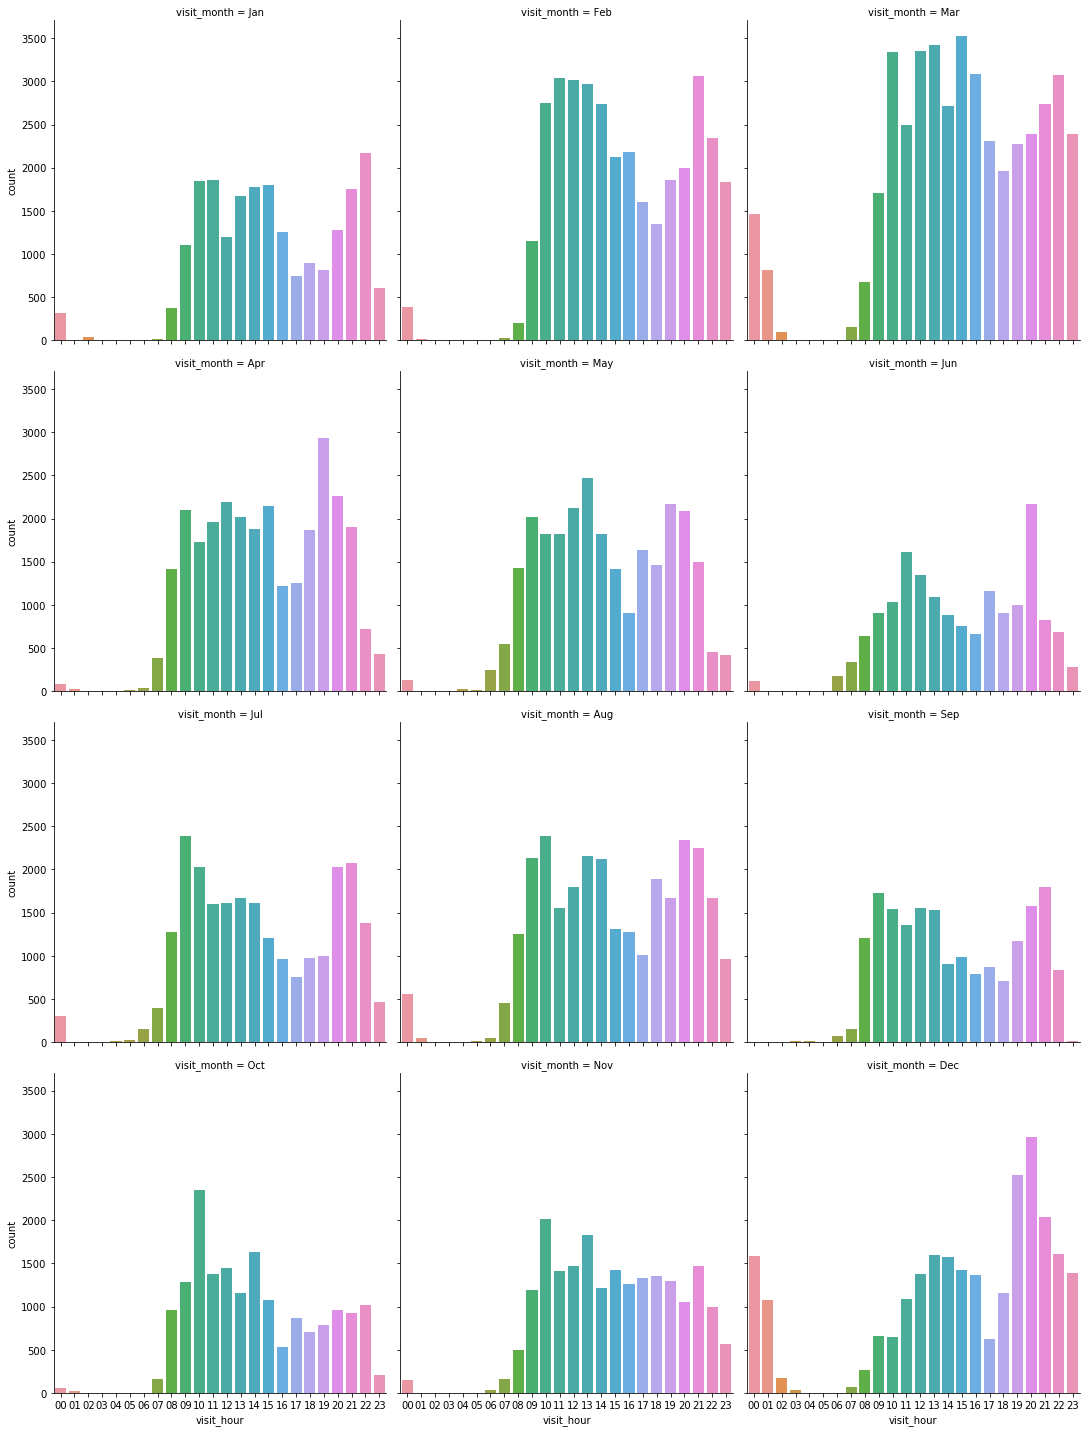

In [1092]:
sns.catplot(x='visit_hour',data=data, 
            kind='count', col='visit_month', col_wrap=3, 
            col_order=months)

## Browsing activity per month

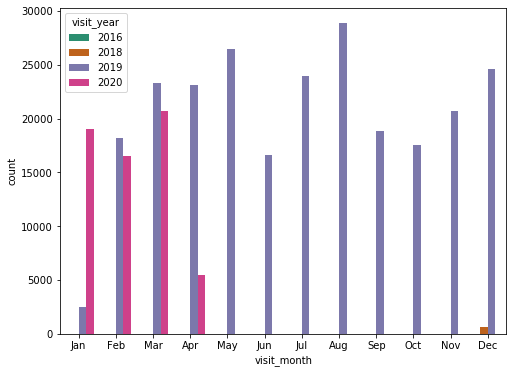

In [1093]:
plt.figure(figsize=(8, 6))
sns.countplot(x='visit_month',data=data, order=months, palette='Dark2', hue='visit_year')

## Browsing activity per year

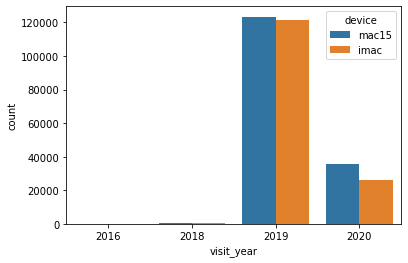

In [1094]:
sns.countplot(x='visit_year',data=data, hue='device')

## Cluster map of hour of day vs day of week

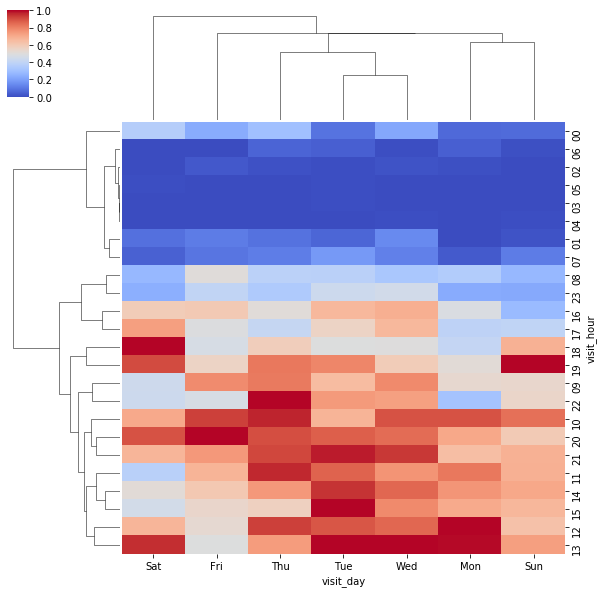

In [1095]:
hour_day = data.pivot_table(index='visit_hour',columns='visit_day', 
                             aggfunc='count', fill_value=0, values='visit_year')
sns.clustermap(hour_day, cmap='coolwarm', standard_scale=1)

## Totoal data

In [1096]:
len(data) # records

306877